In [6]:
!pip install keras==2.1.6 hyperopt==0.1 networkx==1.11
#Note: This works with Python 3.6.8. For Python 3.7, use hyperopt 0.1.2

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv 
import time

import os
from os import listdir
import sys

#Append local dir to path to import custom modules.
local_dir = ""
sys.path.append(os.path.join(local_dir, "models"))

#Sometimes the following modues won't be imported in Colab. Try uploading a new module and adding/removing sys.path.append to get it to work.
from simpleCNN import simple_cnn_model
from deepNN import deep_nn_model
from zeroNN import zero_nn_model
from deepCNN import deep_cnn_model
from VGG import vgg_model
from processModel import MetaModel

#load CIFAR10
from keras.datasets import cifar10
from keras import backend as K

import keras
from keras import layers
from keras.layers import Input, Dense, Activation
from keras.models import Model
from keras.preprocessing import image
from keras import regularizers
from keras.optimizers import Adam, Nadam, Adagrad, Adadelta
from keras.activations import softmax
from keras.losses import sparse_categorical_crossentropy

from hyperopt import hp
from sklearn.model_selection import train_test_split

In [8]:
#Preprocess the data

# input image dimensions
img_rows, img_cols, channels = 32, 32, 3

#Number of possible target values for y.
classes = 10
#File to log model results
model_res_file = 'modelResults_Cifar10.csv'

#Load and setup the meta-model.
meta_model = MetaModel(local_dir, model_res_file)

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
  
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
#Get the cross validation data.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

def plot_train_val(history):
  """Method to plot the out of a call to keras model.fit.
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 validation samples
10000 test samples


In [9]:
#Code to write the columns for the modelResults csv. This info will be logged
#after the models are trained and evaluated.
with open(os.path.join(local_dir, model_res_file), mode='w') as file:
  writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(['networkType', 'trainAcc', 'trainTime (s)', 'testAcc', 'layers', 'epochs', 'activations', 'optim', 'learning_rate','reg_param', 'dropout_prob', 'normTech' , 'misc'])

In [ ]:
#First try logistic regression

#Reshape the data for processing by neural nets
X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols * channels)
X_val = X_val.reshape(X_val.shape[0],  img_rows * img_cols * channels)
X_test = X_test.reshape(X_test.shape[0],  img_rows * img_cols * channels)

#The neural network architectures will be built using combinations of the following parameters.
params = {'classes' : [classes],
          'activation' : ['softmax'],
          'batch_size': [1024],
          'epochs': [1],
          'optimizer': ['adagrad', 'adadelta', 'rmsprop', 'adam', 'nadam'],
          'loss': ['sparse_categorical_crossentropy'],
          'reg_param': [0],
          'callbacks' : [[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')]]}

#Hyperopt will optimize the following parameters in the given ranges.
search_space = {'lr': hp.loguniform('lr', -6, -4)}

#The call to process_model will compile, train and evaulate the above models and optimize the hyper parameters.
#The output will be saved to a file and the output details will be recorded in the model_res_file. 
model_name = "logisticRegression"
meta_model.max_evals = 1
model_results = meta_model.process_model(params, search_space, zero_nn_model, model_name, [X_train, X_val, X_test, y_train, y_val, y_test], 
              [model_name, 0, 0, 0, np.NaN, 'epochs', 'activation', 'optimizer', 'lr','reg_param', 'dropout_prob', np.NaN , np.NaN])

#Now lets plot the results.
history = model_results[0][0]
plot_train_val(history)

W0815 18:47:26.960574 139890393814912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3144: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'classes': 10, 'activation': 'relu', 'batch_size': 1024, 'epochs': 200, 'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'reg_param': 0, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f3a1fd0be80>], 'dropout_prob': 0.3754557343337546, 'lr': 0.00852465672827463}


W0815 18:47:27.310944 139890393814912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1801: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0815 18:47:27.416089 139890393814912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 6s 147us/step - loss: 11.0231 - acc: 0.2158 - val_loss: 11.8123 - val_acc: 0.1509
Epoch 2/200
40000/40000 [==============================] - 3s 66us/step - loss: 10.2140 - acc: 0.2723 - val_loss: 11.7119 - val_acc: 0.1264
Epoch 3/200
40000/40000 [==============================] - 3s 65us/step - loss: 9.1901 - acc: 0.2960 - val_loss: 10.7507 - val_acc: 0.1567
Epoch 4/200
40000/40000 [==============================] - 3s 65us/step - loss: 5.6641 - acc: 0.3332 - val_loss: 3.4723 - val_acc: 0.1951
Epoch 5/200
40000/40000 [==============================] - 3s 66us/step - loss: 2.5977 - acc: 0.3248 - val_loss: 2.0160 - val_acc: 0.3128
Epoch 6/200
40000/40000 [==============================] - 3s 66us/step - loss: 1.7623 - acc: 0.3776 - val_loss: 1.6553 - val_acc: 0.4178
Epoch 7/200
40000/40000 [==============================] - 3s 65us/step - loss: 1.5974 - acc: 0.4377 - val_loss: 1.7

W0815 18:49:45.981048 139890393814912 nn_ops.py:4224] Large dropout rate: 0.551765 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


W0815 18:49:46.118086 139890393814912 nn_ops.py:4224] Large dropout rate: 0.551765 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 3s 86us/step - loss: 9.7549 - acc: 0.2210 - val_loss: 9.9028 - val_acc: 0.2024
Epoch 2/200
40000/40000 [==============================] - 3s 65us/step - loss: 8.9508 - acc: 0.2704 - val_loss: 9.0637 - val_acc: 0.1835
Epoch 3/200
40000/40000 [==============================] - 3s 65us/step - loss: 6.8874 - acc: 0.2802 - val_loss: 13.4499 - val_acc: 0.0998
Epoch 4/200
40000/40000 [==============================] - 3s 66us/step - loss: 4.1604 - acc: 0.2724 - val_loss: 4.6644 - val_acc: 0.1934
Epoch 5/200
40000/40000 [==============================] - 3s 66us/step - loss: 2.4172 - acc: 0.2840 - val_loss: 2.1669 - val_acc: 0.2316
Epoch 6/200
40000/40000 [==============================] - 3s 66us/step - loss: 1.7860 - acc: 0.3689 - val_loss: 2.0426 - val_acc: 0.2555
Epoch 7/200
40000/40000 [==============================] - 3s 66us/step - loss: 1.6266 - acc: 0.4235 - val_loss: 1.9026 -

W0815 18:51:07.043039 139890393814912 nn_ops.py:4224] Large dropout rate: 0.541364 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


W0815 18:51:07.176871 139890393814912 nn_ops.py:4224] Large dropout rate: 0.541364 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 4s 88us/step - loss: 8.6128 - acc: 0.2194 - val_loss: 7.6952 - val_acc: 0.2282
Epoch 2/200
40000/40000 [==============================] - 3s 65us/step - loss: 7.3066 - acc: 0.2979 - val_loss: 7.6075 - val_acc: 0.2364
Epoch 3/200
40000/40000 [==============================] - 3s 65us/step - loss: 7.2595 - acc: 0.3222 - val_loss: 7.3664 - val_acc: 0.2663
Epoch 4/200
40000/40000 [==============================] - 3s 65us/step - loss: 7.1121 - acc: 0.3533 - val_loss: 7.4145 - val_acc: 0.2563
Epoch 5/200
40000/40000 [==============================] - 3s 65us/step - loss: 6.2649 - acc: 0.3774 - val_loss: 7.5948 - val_acc: 0.2066
Epoch 6/200
40000/40000 [==============================] - 3s 65us/step - loss: 5.6395 - acc: 0.4202 - val_loss: 6.0801 - val_acc: 0.3132
Epoch 7/200
40000/40000 [==============================] - 3s 65us/step - loss: 5.0055 - acc: 0.4353 - val_loss: 5.2062 - 

W0815 18:59:39.397234 139890393814912 nn_ops.py:4224] Large dropout rate: 0.543364 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 4s 101us/step - loss: 14.0013 - acc: 0.1006 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 2/200
40000/40000 [==============================] - 3s 65us/step - loss: 14.5156 - acc: 0.0994 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 3/200
40000/40000 [==============================] - 3s 65us/step - loss: 14.5156 - acc: 0.0994 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 4/200
40000/40000 [==============================] - 3s 65us/step - loss: 14.5156 - acc: 0.0994 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 5/200
40000/40000 [==============================] - 3s 66us/step - loss: 14.5156 - acc: 0.0994 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 6/200
40000/40000 [==============================] - 3s 65us/step - loss: 14.5156 - acc: 0.0994 - val_loss: 14.4692 - val_acc: 0.1023
Epoch 7/200
10000/10000 [==============================] - 1s 106us/step
{'classes': 10, 'activation': 'sigmo

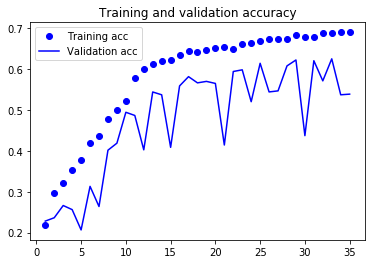

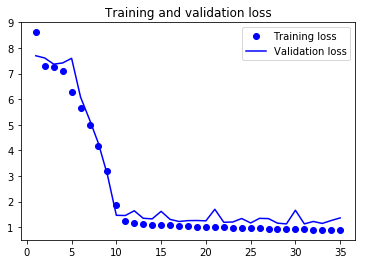

In [0]:
#A simple single stage convolutional neural network

#The neural network architectures will be built using combinations of the following parameters.
params = {'classes' : [classes],
          'activation' : ['relu', 'sigmoid', 'tanh'],
          'batch_size': [1024],
          'epochs': [200],
          'optimizer': ['adam', 'rmsprop'],
          'loss': ['sparse_categorical_crossentropy'],
          'reg_param': [0],
          'callbacks' : [[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=6,
                              verbose=0, mode='auto')]]}

#Hyperopt will optimize the following parameters in the given ranges.
search_space = {'lr': hp.loguniform('lr', -6, -4), 'dropout_prob' : hp.uniform('dropout_prob', 0.0, 0.6)}

#The call to process_model will compile, train and evaulate the above models and optimize the hyper parameters.
#The output will be saved to a file and the output details will be recorded in the model_res_file. 
model_name = "simpleCNN"
meta_model.max_evals = 5
model_results = meta_model.process_model(params, search_space, simple_cnn_model, model_name, [X_train, X_val, X_test, y_train, y_val, y_test], 
              [model_name, 0, 0, 0, np.NaN, 'epochs', 'activation', 'optimizer', 'lr','reg_param', 'dropout_prob', 'batchNorm' , np.NaN])

#Now lets plot the results.
history = model_results[0][0]
plot_train_val(history)

In [0]:
#A multiple stage convolutional neural network

#The neural network architectures will be built using combinations of the following parameters.
params = {'classes' : [classes],
          'activation' : ['relu', 'tanh'],
          'batch_size': [1024],
          'epochs': [200],
          'optimizer': ['rmsprop', 'adam'],
          'loss': ['sparse_categorical_crossentropy'],
          'layers' : [[512, 128], [1024, 512], [4096, 2048]],
          'callbacks' : [[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=6,
                              verbose=0, mode='auto')]]}

#Hyperopt will optimize the following parameters in the given ranges.
search_space = {'lr': hp.loguniform('lr', -8, -6), 'dropout_prob' : hp.uniform('dropout_prob', 0.2, 0.5)}

#The call to process_model will compile, train and evaulate the above models and optimize the hyper parameters.
#The output will be saved to a file and the output details will be recorded in the model_res_file. 
model_name = "deepCNN"
meta_model.max_evals = 5
model_results = meta_model.process_model(params, search_space, deep_cnn_model, model_name, [X_train, X_val, X_test, y_train, y_val, y_test], 
              [model_name, 0, 0, 0, 'layers', 'epochs', 'activation', 'optimizer', 'lr','reg_param', 'dropout_prob', 'batchNorm' , np.NaN])

#Now lets plot the results.
history = model_results[0][0]
plot_train_val(history)

W0815 20:57:49.869309 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 20:57:49.884992 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 20:57:49.893497 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 20:57:49.924626 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:168: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 20:57:49.925660 1399208320

{'classes': 10, 'activation': 'relu', 'batch_size': 1024, 'epochs': 200, 'optimizer': 'rmsprop', 'loss': 'sparse_categorical_crossentropy', 'layers': [512, 128], 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f4188966668>], 'dropout_prob': 0.3084970434581393, 'lr': 0.0008312092311295237}


W0815 20:57:50.438393 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1801: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0815 20:57:50.528940 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0815 20:57:50.537891 139920832087936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3144: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0815 20:57:51.116436 139920832087936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:757: Th

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 8s 203us/step - loss: 2.1401 - acc: 0.3145 - val_loss: 1.7843 - val_acc: 0.3897
Epoch 2/200
40000/40000 [==============================] - 6s 141us/step - loss: 1.6567 - acc: 0.4205 - val_loss: 2.1014 - val_acc: 0.2921
Epoch 3/200
40000/40000 [==============================] - 6s 141us/step - loss: 1.4641 - acc: 0.4784 - val_loss: 3.0784 - val_acc: 0.2195
Epoch 4/200
40000/40000 [==============================] - 6s 142us/step - loss: 1.3313 - acc: 0.5256 - val_loss: 2.8513 - val_acc: 0.2612
Epoch 5/200
40000/40000 [==============================] - 6s 142us/step - loss: 1.2442 - acc: 0.5575 - val_loss: 3.8964 - val_acc: 0.1612
Epoch 6/200
40000/40000 [==============================] - 6s 141us/step - loss: 1.1722 - acc: 0.5839 - val_loss: 1.5858 - val_acc: 0.4739
Epoch 7/200
40000/40000 [==============================] - 6s 141us/step - loss: 1.1175 - acc: 0.6028 - val_loss: 2.

ResourceExhaustedError: ignored

W0818 23:50:34.182018 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 23:50:34.187039 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 23:50:34.223945 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:168: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 23:50:34.225319 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:175: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



{'classes': 10, 'layers': [3, 1024], 'conv_layer_start': 64, 'activation': 'relu', 'batch_size': 512, 'epochs': 50, 'optimizer': 'rmsprop', 'loss': 'sparse_categorical_crossentropy', 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f784f2f69b0>], 'dropout_prob': 0.2262910809311608, 'lr': 0.0005109002007452063}


W0818 23:50:34.713379 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1801: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0818 23:50:34.871857 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0818 23:50:34.878453 140156112357248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3144: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0818 23:50:35.545478 140156112357248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:757: Th

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 21s 530us/step - loss: 1.9608 - acc: 0.3543 - val_loss: 1.5723 - val_acc: 0.4441
Epoch 2/50
40000/40000 [==============================] - 17s 419us/step - loss: 1.4376 - acc: 0.4953 - val_loss: 1.3244 - val_acc: 0.5272
Epoch 3/50
40000/40000 [==============================] - 17s 419us/step - loss: 1.2019 - acc: 0.5740 - val_loss: 1.1426 - val_acc: 0.5955
Epoch 4/50
40000/40000 [==============================] - 17s 419us/step - loss: 1.0621 - acc: 0.6230 - val_loss: 1.0465 - val_acc: 0.6281
Epoch 5/50
40000/40000 [==============================] - 17s 419us/step - loss: 0.9601 - acc: 0.6616 - val_loss: 0.9290 - val_acc: 0.6678
Epoch 6/50
40000/40000 [==============================] - 17s 417us/step - loss: 0.8628 - acc: 0.6964 - val_loss: 0.8918 - val_acc: 0.6850
Epoch 7/50
40000/40000 [==============================] - 17s 418us/step - loss: 0.7999 - acc: 0.7175 - val_loss: 0.

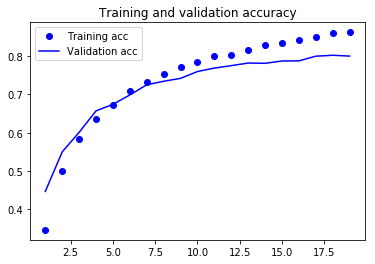

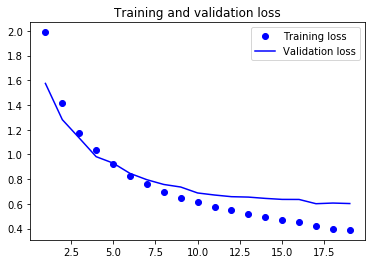

In [0]:
#A VGG network

#The neural network architectures will be built using combinations of the following parameters.
params = {'classes' : [classes],
          'layers' : [[3, 1024]],
          'conv_layer_start' : [64],
          'activation' : ['relu'],
          'batch_size': [512],
          'epochs': [50],
          'optimizer': ['rmsprop'],
          'loss': ['sparse_categorical_crossentropy'],
          'callbacks' : [[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')]]}

#Hyperopt will optimize the following parameters in the given ranges.
search_space = {'lr': hp.loguniform('lr', -8, -6), 'dropout_prob' : hp.uniform('dropout_prob', 0.2, 0.5)}

#The call to process_model will compile, train and evaulate the above models and optimize the hyper parameters.
#The output will be saved to a file and the output details will be recorded in the model_res_file. 
model_name = "VGG"
meta_model.max_evals = 3
model_results = meta_model.process_model(params, search_space, vgg_model, model_name, [X_train, X_val, X_test, y_train, y_val, y_test], 
              [model_name, 0, 0, 0, 'layers', 'epochs', 'activation', 'optimizer', 'lr','reg_param', 'dropout_prob', 'batchNorm' , 'conv_layer_start'])

#Now lets plot the results.
history = model_results[0][0]
plot_train_val(history)

In [7]:
#Display the model results after sorting by test accuracy.
import pandas as pd
data = pd.read_csv(os.path.join(local_dir, model_res_file))
data['testAccPerT'] = 100 * data['testAcc'] / data['trainTime (s)']
data = data.sort_values('testAcc', ascending = False)
data.head(200)

,networkType,trainAcc,trainTime (s),testAcc,layers,epochs,activations,optim,learning_rate,reg_param,dropout_prob,normTech,misc,testAccPerT
32,VGG,0.855225,634.297548,0.7888,3-1024,50,relu,rmsprop,0.000467,NaN,0.443228,NaN,128.0,0.124358
25,VGG,0.864375,196.658036,0.7868,NaN,50,relu,rmsprop,0.001616,NaN,0.271490,NaN,64.0,0.400085
30,VGG,0.847875,244.679290,0.7793,3-1024,50,relu,rmsprop,0.001027,NaN,0.319026,NaN,64.0,0.318499
27,VGG,0.876775,166.077780,0.7691,NaN,50,relu,rmsprop,0.001969,NaN,0.252096,NaN,64.0,0.463096
23,VGG,0.832350,203.996223,0.7642,NaN,200,relu,rmsprop,0.001992,NaN,0.311089,NaN,NaN,0.374615
22,VGG,0.822100,119.169290,0.7623,NaN,25,relu,rmsprop,0.001591,NaN,0.205474,NaN,NaN,0.639678
29,VGG,0.823950,230.599190,0.7552,NaN,50,relu,rmsprop,0.000893,NaN,0.425419,NaN,64.0,0.327495
24,VGG,0.800700,233.410083,0.7474,NaN,50,relu,rmsprop,0.000702,NaN,0.290495,NaN,32.0,0.320209
28,VGG,0.808500,283.771374,0.7368,NaN,50,relu,rmsprop,0.000525,NaN,0.416822,NaN,32.0,0.259646
26,VGG,0.804025,222.012115,0.7351,NaN,50,relu,rmsprop,0.001014,NaN,0.465692,NaN,32.0,0.331108
